In [1]:
# Copyright: European Synchrotron Radiation Facility, Grenoble, France
# Author: V. Valls
# License: MIT

In [2]:
import numpy

In [3]:
def get_minmax_block(array, block_size):
    """Python code to compute min/max cache per block of an image"""
    if block_size == 0:
        return None
    size = numpy.array(array.shape)
    size = size // block_size + (size % block_size > 0)
    min_per_block = numpy.empty(size)
    max_per_block = numpy.empty(size)
    for y in range(size[1]):
        for x in range(size[0]):
            if x + 1 == size[0]:
                xx = slice(x * block_size, array.shape[0])
            else:
                xx = slice(x * block_size, (x + 1) * block_size)
            if y + 1 == size[1]:
                yy = slice(y * block_size, array.shape[1])
            else:
                yy = slice(y * block_size, (y + 1) * block_size)
            min_per_block[x, y] = array[xx, yy].min()
            max_per_block[x, y] = array[xx, yy].max()
    return (min_per_block, max_per_block, block_size)

In [4]:
def count_value(array, minmax_cache, value):
    """Python code to count the number of a specific value using the min/max cache"""
    if minmax_cache is None:
        return numpy.count_nonzero(array == value)

    result = 0
    min_per_block, max_per_block, block_size = minmax_cache
    size = min_per_block.shape
    for y in range(size[1]):
        for x in range(size[0]):
            if min_per_block[x, y] > value:
                continue
            if max_per_block[x, y] < value:
                continue
            if x + 1 == size[0]:
                xx = slice(x * block_size, array.shape[0])
            else:
                xx = slice(x * block_size, (x + 1) * block_size)
            if y + 1 == size[1]:
                yy = slice(y * block_size, array.shape[1])
            else:
                yy = slice(y * block_size, (y + 1) * block_size)
            result += numpy.count_nonzero(array[xx, yy] == value)
    return result

In [5]:
%load_ext Cython

In [6]:
%%cython --cplus

import cython
import numpy
cimport numpy as cnumpy
from libcpp.vector cimport vector
from cython.operator cimport dereference

from libc.float cimport DBL_MAX
cdef double INFINITY = DBL_MAX + DBL_MAX

@cython.initializedcheck(False)
@cython.boundscheck(False)
@cython.wraparound(False)
def get_minmax_block_c(cnumpy.float32_t[:,:] array, int block_size):
    cdef:
        cnumpy.float32_t minimum, maximum, value
        cnumpy.float32_t *value_ptr
        cnumpy.float32_t *array_ptr
        int original_h = array.shape[0]
        int original_w = array.shape[1]
        int h = array.shape[0]
        int w = array.shape[1]
        int x, y
        int xx, yy
        int i = 0
        vector[cnumpy.float32_t] min_per_block
        vector[cnumpy.float32_t] max_per_block
        int y_begin, y_end
        int x_begin, x_end

    with nogil:
        if block_size == 0:
            with gil:
                return None

        w = original_w // block_size
        if original_w % block_size > 0:
            w += 1
        h = original_h // block_size
        if original_h % block_size > 0:
            h += 1
        min_per_block.reserve(w * h)
        max_per_block.reserve(w * h)

        array_ptr = &array[0][0]
        for y in range(h):
            y_begin = y * block_size
            if y + 1 == h:
                y_end = original_h
            else:
                y_end = y_begin + block_size

            for x in range(w):
                x_begin = x * block_size
                if x + 1 == w:
                    x_end = original_w
                else:
                    x_end = x_begin + block_size

                minimum = INFINITY
                maximum = -INFINITY
                value_ptr = array_ptr + original_w * y_begin + x_begin
                for yy in range(y_begin, y_end):
                    for xx in range(x_begin, x_end):
                        value = dereference(value_ptr)
                        value_ptr += 1
                        if value > maximum:
                            maximum = value
                        if value < minimum:
                            minimum = value
                    value_ptr += original_w - (x_end - x_begin)
                min_per_block.push_back(minimum)
                max_per_block.push_back(maximum)

    np_min_per_block = numpy.array(min_per_block)
    np_min_per_block.shape = h, w
    np_max_per_block = numpy.array(max_per_block)
    np_max_per_block.shape = h, w
    return (np_min_per_block, np_max_per_block, block_size)

In [7]:
%%cython --cplus

import cython
import numpy
cimport numpy as cnumpy
from libcpp.vector cimport vector
from cython.operator cimport dereference

from libc.float cimport DBL_MAX
cdef double INFINITY = DBL_MAX + DBL_MAX

@cython.initializedcheck(False)
@cython.boundscheck(False)
@cython.wraparound(False)
def get_minmax_block_c2(cnumpy.float32_t[:,:] array, int block_size):
    """Cython code to compute min/max cache per block of an image.

    This implementation read the input data sequencially to take care of
    the RAM cache.
    """
    cdef:
        cnumpy.float32_t value
        cnumpy.float32_t *value_ptr
        int original_h = array.shape[0]
        int original_w = array.shape[1]
        vector[cnumpy.float32_t] min_per_block
        vector[cnumpy.float32_t] max_per_block
        int block_i, block_w, block_h
        int pixel_i, pixel_x, pixel_y
        int pixel_in_block_x, pixel_in_block_y, pixel_in_row
    with nogil:
        if block_size == 0:
            with gil:
                return None

        block_w = original_w // block_size
        if original_w % block_size > 0:
            block_w += 1
        block_h = original_h // block_size
        if original_h % block_size > 0:
            block_h += 1
        min_per_block.reserve(block_w * block_h)
        max_per_block.reserve(block_w * block_h)

        # Initialize the blocks
        for pixel_i in range(block_w * block_h):
            min_per_block.push_back(INFINITY)
            max_per_block.push_back(-INFINITY)

        # Compute min/max
        value_ptr = &array[0][0]
        block_i = 0
        pixel_in_row = 0
        pixel_in_block_x = 0
        pixel_in_block_y = 0
        for pixel_i in range(original_h * original_w):
            value = dereference(value_ptr)
            if value > max_per_block[block_i]:
                max_per_block[block_i] = value
            if value < min_per_block[block_i]:
                min_per_block[block_i] = value
            value_ptr += 1
            pixel_in_row += 1
            pixel_in_block_x += 1
            if pixel_in_row == original_w:
                block_x = 0
                pixel_in_row = 0
                pixel_in_block_x = 0
                pixel_in_block_y += 1
                if pixel_in_block_y == block_size:
                    block_i += 1
                    pixel_in_block_y = 0
                else:
                    block_i -= block_w - 1
            elif pixel_in_block_x == block_size:
                block_i += 1
                pixel_in_block_x = 0

    np_min_per_block = numpy.array(min_per_block)
    np_min_per_block.shape = block_h, block_w
    np_max_per_block = numpy.array(max_per_block)
    np_max_per_block.shape = block_h, block_w
    return (np_min_per_block, np_max_per_block, block_size)

In [8]:
def assert_minmax_equal(v1, v2):
    numpy.testing.assert_array_equal(v1[0], v2[0])
    numpy.testing.assert_array_equal(v1[1], v2[1])
    assert(v1[2] == v2[2])

assert_minmax_equal((numpy.array([1]), numpy.array([1]), 1), (numpy.array([1]), numpy.array([1]), 1))
# assert_minmax_equal((numpy.array([1]), numpy.array([1]), 1), (numpy.array([1]), numpy.array([2]), 1))

In [9]:
w, h, b = 900, 1021, 128  # 128: optimal block size
array = numpy.arange(w * h, dtype=numpy.float32)
array.shape = w, h
result = [None, None, None]
%timeit result[0] = get_minmax_block(array, b)
%timeit result[1] = get_minmax_block_c(array, b)
%timeit result[2] = get_minmax_block_c2(array, b)
assert_minmax_equal(result[0], result[1])
assert_minmax_equal(result[0], result[2])

1.14 ms ± 12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
775 µs ± 3.17 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.29 ms ± 2.77 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
w, h, b = 4096, 4096, 128  # 128: optimal block size
array = numpy.arange(w * h, dtype=numpy.float32)
array.shape = w, h
result = [None, None, None]
%timeit result[0] = get_minmax_block(array, b)
%timeit result[1] = get_minmax_block_c(array, b)
%timeit result[2] = get_minmax_block_c2(array, b)
assert_minmax_equal(result[0], result[1])
assert_minmax_equal(result[0], result[2])

25.9 ms ± 74 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
29.3 ms ± 43.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
23.7 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
# Check the count algorithm using minmax cache with a data which fit the optimization

w, h, b = 2048, 2048, 128
array = numpy.random.rand(w, h)
array[0:w] += numpy.arange(0, h) * 10
array = numpy.ascontiguousarray(array, dtype=numpy.float32)

minmax_cache = get_minmax_block_c(array, b)
print("Image size: %s" % (array.shape,))
value = array[0, 0]  # take an existing value

a = count_value(array, None, value)
b = count_value(array, minmax_cache, value)
assert(a == b)
print("Value %s found %d times" % (value, a))

print("Without minmax optimization")
%timeit count_value(array, None, value)
print("With minmax optimization")
%timeit count_value(array, minmax_cache, value)

Image size: (2048, 2048)
Value 0.05200577 found 1 times
Without minmax optimization
1.37 ms ± 18.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
With minmax optimization
350 µs ± 1.73 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
try:
    %matplotlib nbagg
except:
    %matplotlib inline

<IPython.core.display.Javascript object>


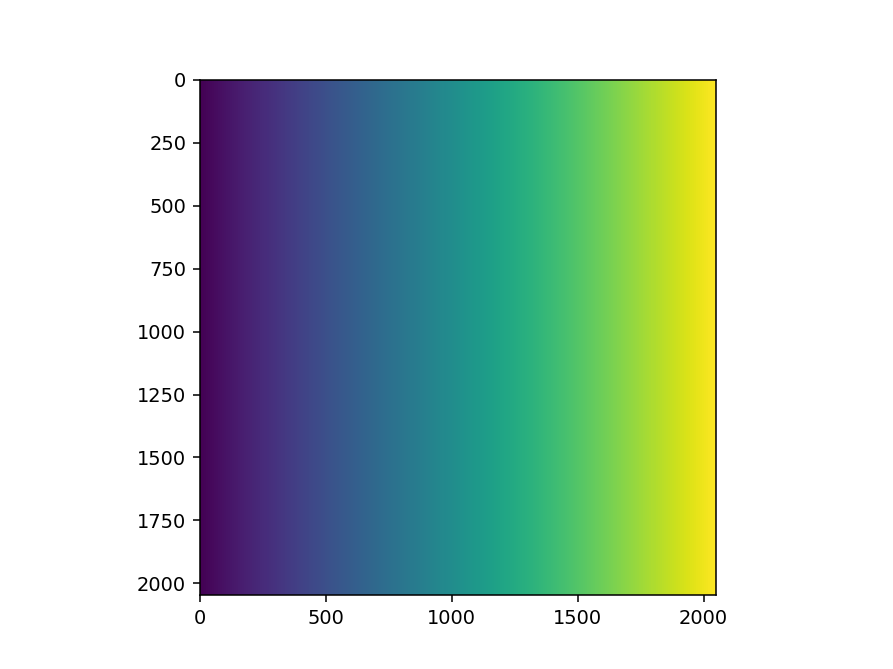

In [13]:
import matplotlib.pyplot as plt
plt.imshow(array)

In [14]:
import timeit
import collections


TimeCollect = collections.namedtuple('TimeCollect', ['image_size',
                                                     'block_size',
                                                     'precachepy_t', 'precachepy_dt',
                                                     'precache1_t', 'precache1_dt',
                                                     'precache2_t', 'precache2_dt',
                                                     'compute_t', 'compute_dt'])

def get_t_dt(array):
    array = numpy.array(array)
    return array.mean(), array.max() - array.mean()

def collect_computation(image_sizes, block_sizes):
    result = []
    for width in image_sizes:
        height = width
        for block_size in block_sizes:
            print("Compute image size %d, block size %d" % (width, block_size))
            array = numpy.random.rand(width, height)
            array[0:w] += numpy.arange(0, height) * 10
            array = numpy.ascontiguousarray(array, dtype=numpy.float32)
            minmax_cache = get_minmax_block_c(array, block_size)
            value = array[0][0]

            scope = dict(globals())
            scope.update(locals())

            precachepy_time = timeit.repeat("get_minmax_block(array, block_size)", number=100, globals=scope)
            precache1_time = timeit.repeat("get_minmax_block_c(array, block_size)", number=100, globals=scope)
            precache2_time = timeit.repeat("get_minmax_block_c2(array, block_size)", number=100, globals=scope)
            compute_time = timeit.repeat("count_value(array, minmax_cache, value)", number=100, globals=scope)
            
            precachepy_time = get_t_dt(precachepy_time)
            precache1_time = get_t_dt(precache1_time)
            precache2_time = get_t_dt(precache2_time)
            compute_time = get_t_dt(compute_time)
            t = TimeCollect(image_size=width,
                            block_size=block_size,
                            precachepy_t=precachepy_time[0],
                            precachepy_dt=precachepy_time[1],
                            precache1_t=precache1_time[0],
                            precache1_dt=precache1_time[1],
                            precache2_t=precache2_time[0],
                            precache2_dt=precache2_time[1],
                            compute_t=compute_time[0],
                            compute_dt=compute_time[1])
            result.append(t)
    return result

block_sizes = [0, 16, 32, 64, 128, 256, 512, 1024]
image_sizes = [512, 1024, 2048, 4096]
# collected_result = collect_computation(image_sizes, block_sizes)
# print(collected_result)

In [15]:
collected_result = [TimeCollect(image_size=512, block_size=0, precachepy_t=2.0789000700460747e-05, precachepy_dt=1.2800010154023767e-06, precache1_t=0.00010394733180874027, precache1_dt=3.4686672734096646e-06, precache2_t=0.00010124666732735932, precache2_dt=7.426333468174562e-06, compute_t=0.009655953000522762, compute_dt=0.0004319219976120312), TimeCollect(image_size=512, block_size=16, precachepy_t=0.7069883673333001, precachepy_dt=0.09933407066516031, precache1_t=0.051941730665324336, precache1_dt=8.003833378703723e-05, precache2_t=0.05627198366710218, precache2_dt=0.00016738633348722942, compute_t=0.033641475334055336, compute_dt=0.000287559668019334), TimeCollect(image_size=512, block_size=32, precachepy_t=0.18637484066615193, precachepy_dt=0.0008305293328400298, precache1_t=0.03612193499914914, precache1_dt=0.000284789001549747, precache2_t=0.04326534800081087, precache2_dt=0.0005073969999405889, compute_t=0.01399828866609217, compute_dt=8.814033450713944e-05), TimeCollect(image_size=512, block_size=64, precachepy_t=0.06903640933402737, precachepy_dt=0.000666309665878842, precache1_t=0.027561372332759976, precache1_dt=0.00033428366684044516, precache2_t=0.0366178779998639, precache2_dt=0.0006520849989707714, compute_t=0.008142073333146982, compute_dt=4.095066469744779e-05), TimeCollect(image_size=512, block_size=128, precachepy_t=0.03323837499920046, precachepy_dt=0.00034683199919527397, precache1_t=0.02477978033493855, precache1_dt=2.8541664505610242e-05, precache2_t=0.03433690833238264, precache2_dt=0.00026937766475990804, compute_t=0.007036415664818681, compute_dt=7.14713338917745e-05), TimeCollect(image_size=512, block_size=256, precachepy_t=0.02097841266489316, precachepy_dt=7.349633475920922e-05, precache1_t=0.022903657332790317, precache1_dt=1.455066740163602e-05, precache2_t=0.03273575033260082, precache2_dt=0.00044947566614913365, compute_t=0.009216675000061514, compute_dt=0.0001615430010133423), TimeCollect(image_size=512, block_size=512, precachepy_t=0.008732814333294906, precachepy_dt=5.873666790042441e-05, precache1_t=0.02204977800162548, precache1_dt=6.672199864017972e-05, precache2_t=0.03225158733281811, precache2_dt=0.00019108566751432216, compute_t=0.005976527666158897, compute_dt=0.0004485903349025948), TimeCollect(image_size=512, block_size=1024, precachepy_t=0.008770481998605343, precachepy_dt=7.582399969881769e-05, precache1_t=0.022115056335072342, precache1_dt=3.4059665874035944e-05, precache2_t=0.03207507533443277, precache2_dt=6.511566607514396e-05, compute_t=0.006066297332533092, compute_dt=0.00044458666646581425), TimeCollect(image_size=1024, block_size=0, precachepy_t=1.685499955783598e-05, precachepy_dt=6.890997610753402e-06, precache1_t=6.4044666942209e-05, precache1_dt=2.2353342501446605e-06, precache2_t=6.409066554624587e-05, precache2_dt=3.795332304434851e-06, compute_t=0.02035519566682827, compute_dt=0.00011584333212037376), TimeCollect(image_size=1024, block_size=16, precachepy_t=2.4539357506655506, precachepy_dt=0.01468243033377803, precache1_t=0.18864302966782512, precache1_dt=0.00036410633523095703, precache2_t=0.22172300433400474, precache2_dt=0.00028853766828737526, compute_t=0.10187061266575863, compute_dt=0.0003539783331992369), TimeCollect(image_size=1024, block_size=32, precachepy_t=0.7118065546662061, precachepy_dt=0.004124500331575631, precache1_t=0.13824970366598185, precache1_dt=0.00038999433187805743, precache2_t=0.16931703833324718, precache2_dt=0.0014384046662598848, compute_t=0.03613671833227272, compute_dt=0.0001243176666321233), TimeCollect(image_size=1024, block_size=64, precachepy_t=0.25357132866580895, precachepy_dt=0.0009408553354053883, precache1_t=0.10899142033182822, precache1_dt=0.0001158206662997402, precache2_t=0.14344487100000455, precache2_dt=0.00022584299828545817, compute_t=0.0178000756665521, compute_dt=0.00014557233347052903), TimeCollect(image_size=1024, block_size=128, precachepy_t=0.12462534533430396, precachepy_dt=0.0015156256680105146, precache1_t=0.10109993733325003, precache1_dt=0.0004316186665770799, precache2_t=0.13360344200070054, precache2_dt=0.0001440829995165982, compute_t=0.014309780667341935, compute_dt=1.564433235519934e-05), TimeCollect(image_size=1024, block_size=256, precachepy_t=0.08064342499953152, precachepy_dt=0.0018864829993011228, precache1_t=0.09166037633500916, precache1_dt=0.0002088486665646344, precache2_t=0.12941273233445827, precache2_dt=0.000267654668277828, compute_t=0.01764733266706268, compute_dt=2.0766333667172204e-05), TimeCollect(image_size=1024, block_size=512, precachepy_t=0.06276007599929774, precachepy_dt=5.426700105697069e-05, precache1_t=0.08809171866717709, precache1_dt=0.0005724893332323261, precache2_t=0.1272920713320976, precache2_dt=0.0005912996663634262, compute_t=0.028466330002023216, compute_dt=7.389200133426851e-05), TimeCollect(image_size=1024, block_size=1024, precachepy_t=0.028929680000146618, precachepy_dt=5.445300121209584e-05, precache1_t=0.0856406389999999, precache1_dt=0.0006525270012692347, precache2_t=0.12629916133300867, precache2_dt=0.00027517466514836997, compute_t=0.020480979332205607, compute_dt=2.4560667952755466e-05), TimeCollect(image_size=2048, block_size=0, precachepy_t=1.2594665652917078e-05, precachepy_dt=1.0243335661167894e-06, precache1_t=6.092466719564982e-05, precache1_dt=2.0023326214868575e-06, precache2_t=6.097100049373694e-05, precache2_dt=3.3520009310450405e-06, compute_t=0.13560905066818427, compute_dt=0.0015889823322746965), TimeCollect(image_size=2048, block_size=16, precachepy_t=10.627105886665959, precachepy_dt=0.07753532533388352, precache1_t=0.7635867663326886, precache1_dt=0.004967670667004653, precache2_t=0.8895851209987692, precache2_dt=0.0017820000005789316, compute_t=0.35610303499925067, compute_dt=0.002204330998210935), TimeCollect(image_size=2048, block_size=32, precachepy_t=3.0711531593333348, precachepy_dt=0.0022137126652523875, precache1_t=0.5583951003342614, precache1_dt=0.0010613076677449262, precache2_t=0.6657407576676633, precache2_dt=0.0008137673321471084, compute_t=0.11008038566554508, compute_dt=0.002280550334641404), TimeCollect(image_size=2048, block_size=64, precachepy_t=1.1125206870007485, precachepy_dt=0.006695800000064311, precache1_t=0.5675450766660409, precache1_dt=0.006563195331788507, precache2_t=0.6022243936677114, precache2_dt=0.0069620813337678555, compute_t=0.04429739299909367, compute_dt=0.00021839299855249544), TimeCollect(image_size=2048, block_size=128, precachepy_t=0.5597316529989863, precachepy_dt=0.00334840099943301, precache1_t=0.5503869359999953, precache1_dt=0.007399079000606434, precache2_t=0.5457059866675991, precache2_dt=0.004131740330194589, compute_t=0.0309531450002396, compute_dt=0.0003935089989681728), TimeCollect(image_size=2048, block_size=256, precachepy_t=0.40341559233274893, precachepy_dt=0.002794722666294547, precache1_t=0.42024582899951685, precache1_dt=0.0009118479999112306, precache2_t=0.5234345556673361, precache2_dt=0.0016690903321432415, compute_t=0.045402747335174354, compute_dt=0.000182169667823473), TimeCollect(image_size=2048, block_size=512, precachepy_t=0.31820226566681714, precachepy_dt=0.0030164453334388663, precache1_t=0.3673324889993334, precache1_dt=0.0016067449990562754, precache2_t=0.5151073103334056, precache2_dt=0.0004472866639844142, compute_t=0.07201807299861684, compute_dt=0.0007023469988780562), TimeCollect(image_size=2048, block_size=1024, precachepy_t=0.2996330279990313, precachepy_dt=0.0034726950010129376, precache1_t=0.36487700966608827, precache1_dt=0.002097379336191807, precache2_t=0.5161798623339564, precache2_dt=0.0031873706648184452, compute_t=0.12312305900074232, compute_dt=0.0005321910005780667), TimeCollect(image_size=4096, block_size=0, precachepy_t=1.3293001150789982e-05, precachepy_dt=1.023998872066537e-06, precache1_t=6.439366795045014e-05, precache1_dt=1.9553347859376375e-06, precache2_t=6.455666516558267e-05, precache2_dt=3.888333594659343e-06, compute_t=0.7034607076651204, compute_dt=0.002329183333737661), TimeCollect(image_size=4096, block_size=16, precachepy_t=42.676168085332996, precachepy_dt=0.01873927766913397, precache1_t=3.2366661993328307, precache1_dt=0.00038293966645142063, precache2_t=3.5261890030002783, precache2_dt=0.0017761100001130181, compute_t=1.3133917383335454, compute_dt=0.008828566665518567), TimeCollect(image_size=4096, block_size=32, precachepy_t=12.873826623332812, precachepy_dt=0.010292230666285818, precache1_t=2.5600988549995236, precache1_dt=0.004900576997897588, precache2_t=2.6768154433339078, precache2_dt=0.0004998076656193007, compute_t=0.3758513796662252, compute_dt=0.002878904332950072), TimeCollect(image_size=4096, block_size=64, precachepy_t=4.849494176002433, precachepy_dt=0.004998144000031068, precache1_t=3.0667160956666826, precache1_dt=0.002564991331988953, precache2_t=2.3202599533324246, precache2_dt=0.003482193664240185, compute_t=0.11961302233369982, compute_dt=0.002150785664222596), TimeCollect(image_size=4096, block_size=128, precachepy_t=2.5956462296671816, precachepy_dt=0.004084435331606073, precache1_t=2.6235541310015833, precache1_dt=0.008221041000069818, precache2_t=2.189009649999207, precache2_dt=0.011801361000834731, compute_t=0.08896580600048765, compute_dt=0.00012995100041734986), TimeCollect(image_size=4096, block_size=256, precachepy_t=1.8376018343333271, precachepy_dt=0.004136210664000828, precache1_t=1.5884249896674494, precache1_dt=0.0038600343347450217, precache2_t=2.0983064956672024, precache2_dt=0.0003440383334236685, compute_t=0.10448682066756494, compute_dt=0.0011019563304823093), TimeCollect(image_size=4096, block_size=512, precachepy_t=1.433002176334412, precachepy_dt=0.003991452664195094, precache1_t=1.5108762083339873, precache1_dt=0.004310464667166114, precache2_t=2.0617391356657513, precache2_dt=0.002408337334296906, compute_t=0.15851813266635872, compute_dt=0.00026288233493687585), TimeCollect(image_size=4096, block_size=1024, precachepy_t=1.2946860066670827, precachepy_dt=0.006567385333861919, precache1_t=1.4818064506677426, precache1_dt=0.004817093334471112, precache2_t=2.0469593236666697, precache2_dt=0.0034558863335405476, compute_t=0.2686063873346332, compute_dt=0.0011017236671856945)]

In [16]:
import numpy
import matplotlib.pyplot as plt
import pylab

def get_image_sizes(collected_result):
    result = set([r.image_size for r in collected_result])
    result = sorted(result)
    return result

def get_result_per_image_size(collected_result, image_size):
    result = [r for r in collected_result if r.image_size == image_size]
    result = sorted(result, key=lambda r: r.block_size)
    return result

colors = ["green", "yellow", "orange", "red"]

<IPython.core.display.Javascript object>


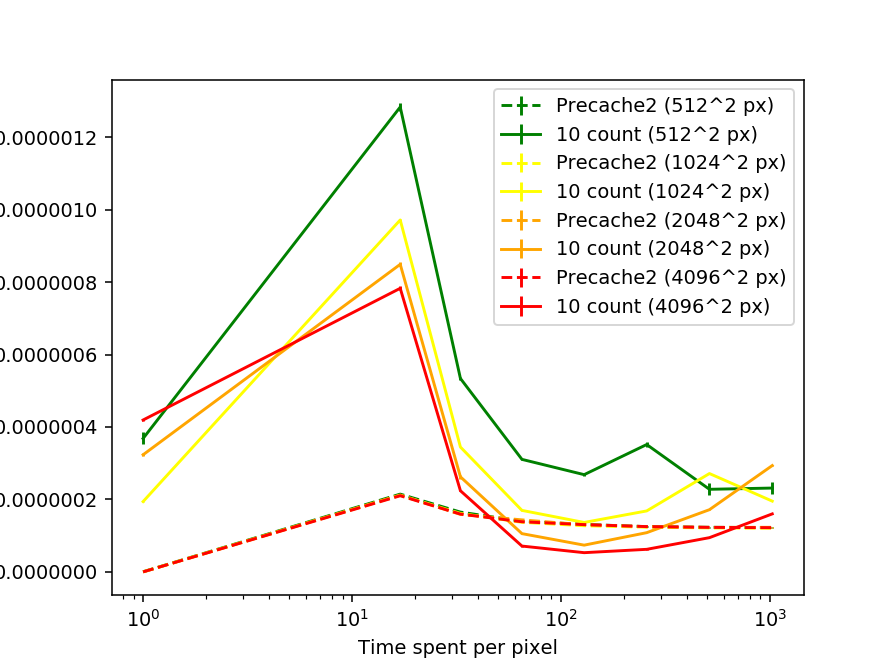

In [17]:
def plot_compute(collected_result, nb_compute):
    image_sizes = get_image_sizes(collected_result)

    plt.figure()
    for i, image_size in enumerate(image_sizes):
        result = get_result_per_image_size(collected_result, image_size)
        pixel_count = image_size * image_size
        color = colors[i % len(colors)]
        x = numpy.array([r.block_size for r in result]) + 1
        cache_y = numpy.array([r.precache2_t for r in result]) / pixel_count
        cache_error = numpy.array([r.precache2_dt for r in result]) / pixel_count
        compute_y = numpy.array([r.compute_t for r in result]) * nb_compute / pixel_count
        compute_error = numpy.array([r.compute_dt for r in result]) * nb_compute / pixel_count
        plt.errorbar(x=x, y=cache_y, yerr=cache_error, color=color, linestyle="--", label="Precache2 (%d^2 px)" % image_size)
        plt.errorbar(x=x, y=compute_y, yerr=compute_error, color=color, linestyle="-", label="%d count (%d^2 px)" % (nb_compute, image_size))

    pylab.legend()
    plt.gca().set_xscale("log", nonposx='clip')
    pylab.xlabel("Time spent per pixel")
    plt.legend
    plt.show()

# Check computation time vs precache time
plot_compute(collected_result, nb_compute=10)

<IPython.core.display.Javascript object>


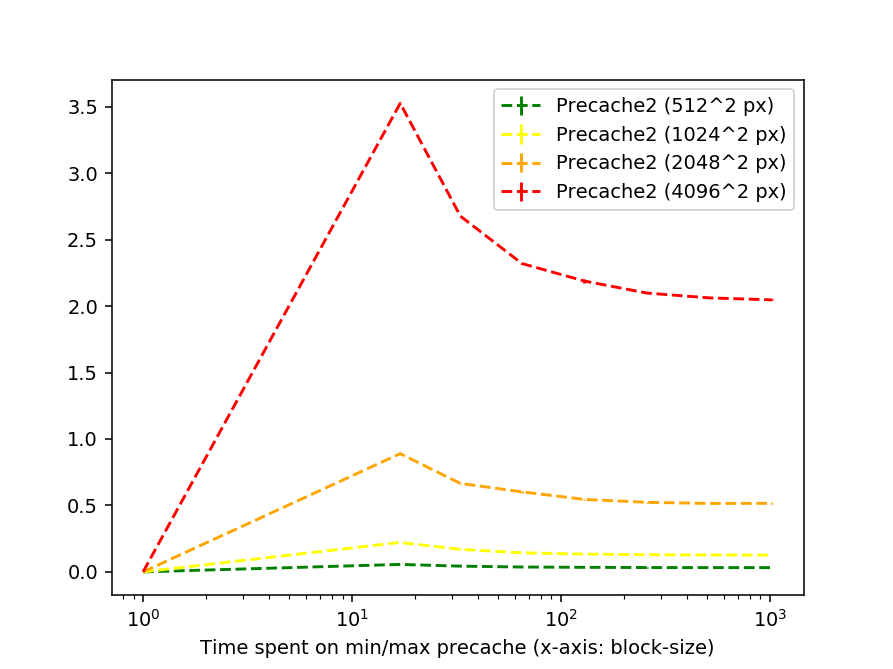

In [18]:
def plot_cache(collected_result):
    image_sizes = get_image_sizes(collected_result)

    plt.figure()
    for i, image_size in enumerate(image_sizes):
        result = get_result_per_image_size(collected_result, image_size)
        pixel_count = image_size * image_size
        color = colors[i % len(colors)]
        x = numpy.array([r.block_size for r in result]) + 1
        cache_y = numpy.array([r.precache2_t for r in result])
        cache_error = numpy.array([r.precache2_dt for r in result])
        plt.errorbar(x=x, y=cache_y, yerr=cache_error, color=color, linestyle="--", label="Precache2 (%d^2 px)" % image_size)
    pylab.legend()
    plt.gca().set_xscale("log", nonposx='clip')
    pylab.xlabel("Time spent on min/max precache (x-axis: block-size)")
    plt.legend
    plt.show()

# Check precache computation
plot_cache(collected_result)

<IPython.core.display.Javascript object>


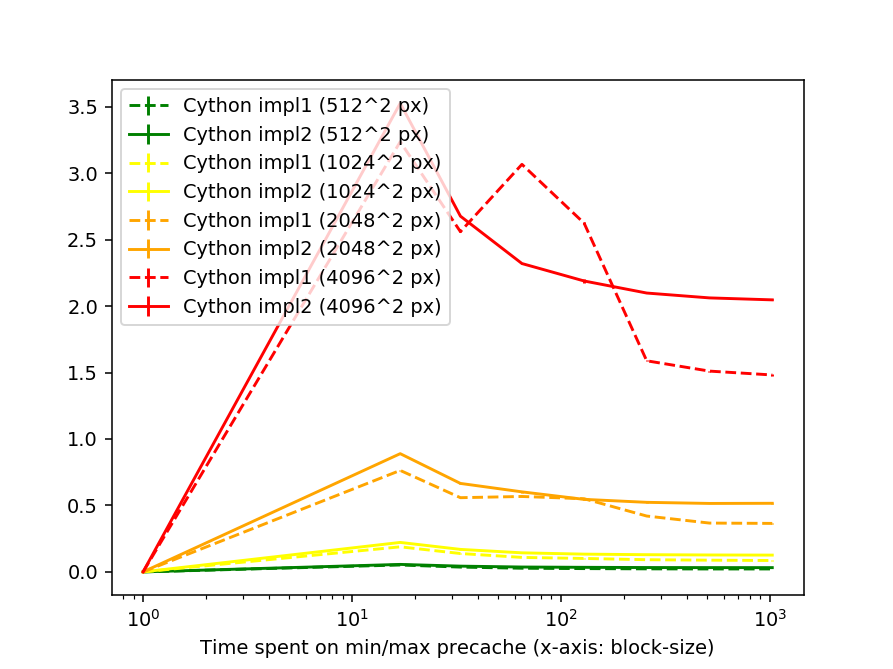

<IPython.core.display.Javascript object>


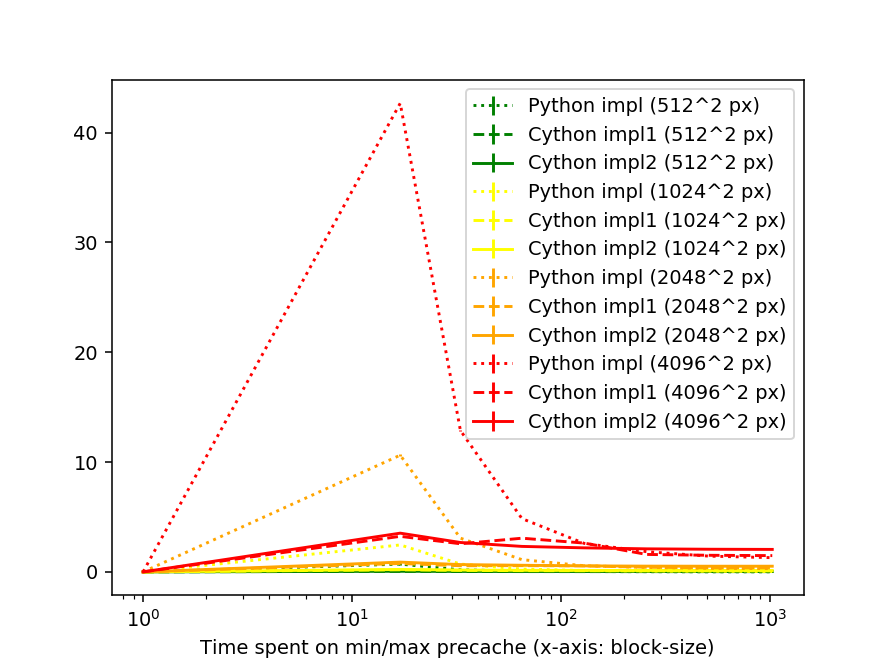

In [19]:
def plot_cache_compare(collected_result, pyimpl=False):
    image_sizes = get_image_sizes(collected_result)

    plt.figure()
    for i, image_size in enumerate(image_sizes):
        result = get_result_per_image_size(collected_result, image_size)
        pixel_count = image_size * image_size
        color = colors[i % len(colors)]
        x = numpy.array([r.block_size for r in result]) + 1

        if pyimpl:
            precachepy_y = numpy.array([r.precachepy_t for r in result])
            precachepy_error = numpy.array([r.precachepy_dt for r in result])
            plt.errorbar(x=x, y=precachepy_y, yerr=precachepy_error, color=color, linestyle=":", label="Python impl (%d^2 px)" % image_size)

        precache1_y = numpy.array([r.precache1_t for r in result])
        precache1_error = numpy.array([r.precache1_dt for r in result])
        plt.errorbar(x=x, y=precache1_y, yerr=precache1_error, color=color, linestyle="--", label="Cython impl1 (%d^2 px)" % image_size)

        precache2_y = numpy.array([r.precache2_t for r in result])
        precache2_error = numpy.array([r.precache2_dt for r in result])
        plt.errorbar(x=x, y=precache2_y, yerr=precache2_error, color=color, linestyle="-", label="Cython impl2 (%d^2 px)" % image_size)

    pylab.legend()
    plt.gca().set_xscale("log", nonposx='clip')
    pylab.xlabel("Time spent on min/max precache (x-axis: block-size)")
    plt.legend
    plt.show()

# Compare Cython precache computation
plot_cache_compare(collected_result)
plot_cache_compare(collected_result, pyimpl=True)